<a href="https://colab.research.google.com/github/BigFoots625/TUGASRISET_NLP/blob/main/TUGASRISET_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORT LIBRARY**

In [65]:
!pip install Sastrawi


In [66]:
# Core
import pandas as pd
import numpy as np
import re

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# ML
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

# Visual
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **LOAD DATASET**

In [67]:
from google.colab import files
uploaded = files.upload()
import io
filename = next(iter(uploaded))
df = pd.read_csv(io.BytesIO(uploaded[filename]))
print("File:", filename)
print("Shape:", df.shape)
df.head()

Saving tokopedia-product-reviews-2019.csv to tokopedia-product-reviews-2019 (2).csv
File: tokopedia-product-reviews-2019 (2).csv
Shape: (40607, 9)


,Unnamed: 0,text,rating,category,product_name,product_id,sold,shop_id,product_url
0,1,Barang sesuai pesanan dan cepat sampai,5,pertukangan,Staples Dekorasi Staples Kayu + Refill 8mm - S...,418660637,1,1740837,https://www.tokopedia.com/shakaonline87/staple...
1,2,Barang bagus harga murah,5,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,416032545,11,1477109,https://www.tokopedia.com/juraganperkakas/stap...
2,3,Paket rapi...mantap....cepat....sampe ke tujuan,5,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,416032545,11,1477109,https://www.tokopedia.com/juraganperkakas/stap...
3,4,ya saya puas dgn barangnya,5,pertukangan,ALAT STAPLES TEMBAK &#40;AIR NAILER GUN&#41; O...,102279869,5,771395,https://www.tokopedia.com/kamarmesin/alat-stap...
4,5,Responya luar biasa b mantap,5,pertukangan,Isi Refill Staples Jok Kulit Motor / Staple Gu...,190679689,787,969999,https://www.tokopedia.com/mitrapersada/isi-ref...


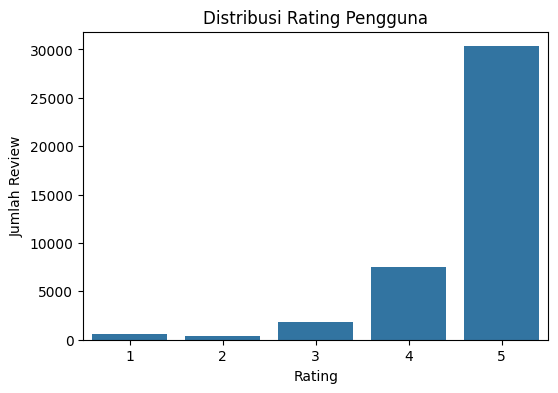

In [68]:
plt.figure(figsize=(6,4))
sns.countplot(x='rating', data=df)
plt.title('Distribusi Rating Pengguna')
plt.xlabel('Rating')
plt.ylabel('Jumlah Review')
plt.show()


# **PROCESSING LABEL SENTIMEN**

In [69]:
def label_sentiment(r):
    if r >= 4:
        return 'positive'
    elif r <= 2:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['rating'].apply(label_sentiment)
df = df[df['sentiment'] != 'neutral']
df['sentiment'].value_counts()


,count
sentiment,
positive,37857
negative,925


# **TEXT PREPROCESSING**

cleaning text

In [70]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

df['clean'] = df['text'].apply(clean_text)


**normalisasi**

In [71]:
normalisasi = {
    'gk':'tidak','ga':'tidak','bgt':'banget',
    'brg':'barang','cepet':'cepat','jg':'juga'
}

def normalize(text):
    return ' '.join([normalisasi.get(w, w) for w in text.split()])

df['normalized'] = df['clean'].apply(normalize)


tokenisasi

In [72]:
df['tokens'] = df['normalized'].apply(word_tokenize)


stopwords

In [73]:
stop_words = set(stopwords.words('indonesian'))
df['no_stopwords'] = df['tokens'].apply(
    lambda x: [w for w in x if w not in stop_words]
)


stemming

In [78]:
stemmer = StemmerFactory().create_stemmer()
df['stemmed'] = df['no_stopwords'].apply(
    lambda x: [stemmer.stem(w) for w in x]
)


final preprocessing

In [80]:
df['final_text'] = df['stemmed'].apply(lambda x: ' '.join(x))

df[['text','final_text','sentiment']].head()


,text,final_text,sentiment
0,Barang sesuai pesanan dan cepat sampai,barang sesuai pesan cepat,positive
1,Barang bagus harga murah,barang bagus harga murah,positive
2,Paket rapi...mantap....cepat....sampe ke tujuan,paket rapimantapcepatsampe tuju,positive
3,ya saya puas dgn barangnya,ya puas dgn barang,positive
4,Responya luar biasa b mantap,responya b mantap,positive


# **EDA**

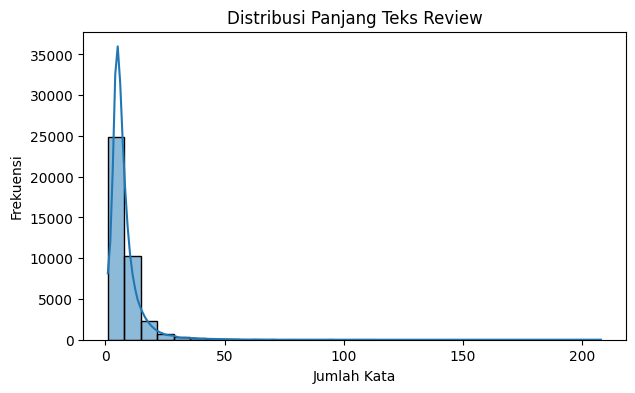

In [81]:
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(7,4))
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title('Distribusi Panjang Teks Review')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()


# **ANALISIS PREPROCESSING**

In [82]:
sample = df.sample(5, random_state=42)
sample[['text','clean','normalized','final_text']]


,text,clean,normalized,final_text
15647,Mantappp...............,mantappp,mantappp,mantappp
26863,Sip sip sip Sip sip sip Sip sip sip Sip sip sip,sip sip sip sip sip sip sip sip sip sip sip sip,sip sip sip sip sip sip sip sip sip sip sip sip,sip sip sip sip sip sip sip sip sip sip sip sip
23721,"Barang cepat sampai, untuk konfigurasi belum d...",barang cepat sampai untuk konfigurasi belum di...,barang cepat sampai untuk konfigurasi belum di...,barang cepat konfigurasi coba
36009,Barang sudah diterima n di cek kualitas oke ka...,barang sudah diterima n di cek kualitas oke ka...,barang sudah diterima n di cek kualitas oke ka...,barang terima n cek kualitas oke kayak gak gam...
28239,fast respon.. n test langsung,fast respon n test langsung,fast respon n test langsung,fast respon n test langsung


# **TF-IDF VECTORIZE**

In [83]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2)
)

X = tfidf.fit_transform(df['final_text'])
y = df['sentiment']


# **ANALISIS TF IDF**

In [84]:
tfidf_df = pd.DataFrame(
    X.toarray(),
    columns=tfidf.get_feature_names_out()
)

tfidf_df.mean().sort_values(ascending=False).head(10)


,0
barang,0.062665
sesuai,0.047868
cepat,0.039763
terima,0.037540
bagus,0.035900
kirim,0.027217
barang sesuai,0.025380
kasih,0.021910
pesan,0.021575
gan,0.019430


# **SPLIT DATA**

In [85]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# **MODEL 1: NAIVE BAIYES**

In [86]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
pred_nb = nb.predict(X_test)

print("Naive Bayes\n", classification_report(y_test, pred_nb))


Naive Bayes
               precision    recall  f1-score   support

    negative       0.80      0.09      0.16       185
    positive       0.98      1.00      0.99      7572

    accuracy                           0.98      7757
   macro avg       0.89      0.54      0.57      7757
weighted avg       0.97      0.98      0.97      7757



# **MODEL 2: SUPPORT VECTOR MACHINE**

In [87]:
svm = LinearSVC()
svm.fit(X_train, y_train)
pred_svm = svm.predict(X_test)

print("SVM\n", classification_report(y_test, pred_svm))


SVM
               precision    recall  f1-score   support

    negative       0.69      0.29      0.41       185
    positive       0.98      1.00      0.99      7572

    accuracy                           0.98      7757
   macro avg       0.84      0.64      0.70      7757
weighted avg       0.98      0.98      0.98      7757



# **CONFUSION MATRIX**

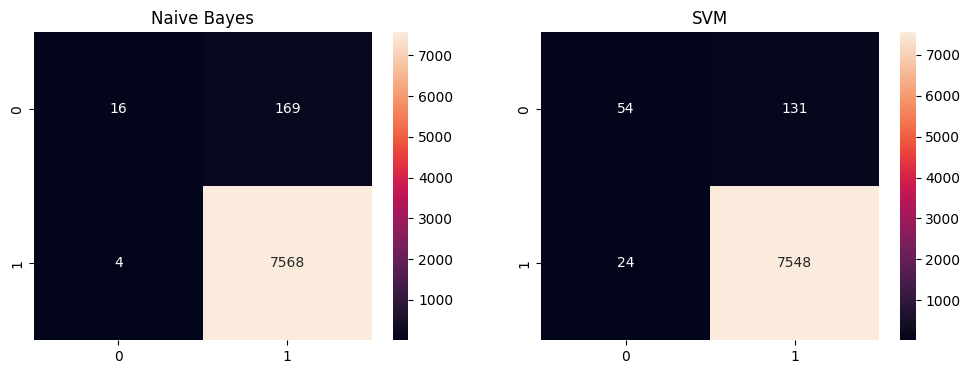

In [88]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_test, pred_nb), annot=True, fmt='d')
plt.title('Naive Bayes')

plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test, pred_svm), annot=True, fmt='d')
plt.title('SVM')

plt.show()


# **MODEL COMPARISON**

In [89]:
cv_nb = cross_val_score(nb, X, y, cv=5, scoring='f1_macro')
cv_svm = cross_val_score(svm, X, y, cv=5, scoring='f1_macro')

print("NB CV F1:", cv_nb.mean())
print("SVM CV F1:", cv_svm.mean())


NB CV F1: 0.5654069035469036
SVM CV F1: 0.681718091412059


# **HASIL AKHIR**

In [90]:
result = df[['text','rating','sentiment']].copy()
result['predicted'] = svm.predict(X)
result.head()


,text,rating,sentiment,predicted
0,Barang sesuai pesanan dan cepat sampai,5,positive,positive
1,Barang bagus harga murah,5,positive,positive
2,Paket rapi...mantap....cepat....sampe ke tujuan,5,positive,positive
3,ya saya puas dgn barangnya,5,positive,positive
4,Responya luar biasa b mantap,5,positive,positive
